In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv004.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# MICCAI 2023 simulation experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

In [4]:
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --n_layers {n_layers} \\
    --activ_fn {activ_fn} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{noise_ratio:.0e}_{savgol_filter}_{omega}_{pde_name}'

param_space = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    noise_ratio=[0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    omega=[60],
    n_layers=[5],
    activ_fn=['ss'],
    savgol_filter=[0, 1],
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)

len(param_space)

144

In [5]:
name.format(**list(param_space)[0])

'train_fem_box_50_0e+00_0_60_helmholtz'

In [6]:
%autoreload

expt_name = '2023-2-24_sim_noise2'

#jobs = ps.submit(template, name, list(param_space), work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [13]:
%autoreload
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs, parse_stdout=True, parse_stderr=True)
status[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
14688853,train_fem_box_50_0e+00_0_60_helmholtz,NaN,NaN,NaN,v031,
14688854,train_fem_box_50_0e+00_0_60_hetero,NaN,NaN,NaN,v030,
14688855,train_fem_box_50_0e+00_1_60_helmholtz,NaN,NaN,NaN,v022,
14688856,train_fem_box_50_0e+00_1_60_hetero,NaN,NaN,NaN,v020,
14688857,train_fem_box_50_1e-05_0_60_helmholtz,NaN,NaN,NaN,v026,
...,...,...,...,...,...,...
14688992,train_fem_box_100_1e-02_1_60_hetero,NaN,NaN,NaN,v032,
14688993,train_fem_box_100_1e-01_0_60_helmholtz,NaN,NaN,NaN,v003,
14688994,train_fem_box_100_1e-01_0_60_hetero,NaN,NaN,NaN,v005,


In [14]:
def get_error_type(e):
    for error_type in [
        'CANCELLED',
        'python: command not found',
        'Unexpected error from cudaGetDeviceCount()'
    ]:
        if error_type in e:
            return error_type
    return e

status['has_stderr_file'] = status.stderr.map(lambda x: not (isinstance(x, float) and np.isnan(x)))
status['has_stderr'] = ~status.stderr.isnull() & ~(status.stderr == '')
status['error'] = status.stderr.astype(str).map(get_error_type)

status.fillna('DONE').groupby(['job_state', 'has_stderr_file', 'has_stderr', 'error'])[['job_name']].count()

,,,,job_name
job_state,has_stderr_file,has_stderr,error,
DONE,True,False,,144


In [15]:
status[status.has_stderr].groupby(['error', 'stdout'])[['job_name']].count()

,,job_name
error,stdout,


In [10]:
metrics = ps.metrics(jobs)

# did all models train to completion?
#assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id', 'noise_ratio'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

a_pred_MSAV  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                
helmholtz 50         0.0         all                   all                     0.0   
                                                       1                       NaN   
                                                       2                       NaN   
                                                       3                       NaN   
                                                       4                       NaN   
...                                                                            ...   
hetero    100        0.1         6.0                   all                     NaN   
                                 7.0                   all                     NaN   
                                 8.0                   all                     NaN   
                                 9.0                   all                     NaN   
                                 10.0                  all                     NaN   

                                                                       a_pred_MSAE  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                
helmholtz 50         0.0         all                   all                     0.0   
                                                       1                       NaN   
                                                       2                       NaN   
                                                       3                       NaN   
                                                       4                       NaN   
...                                                                            ...   
hetero    100        0.1         6.0                   all                     NaN   
                                 7.0                   all                     NaN   
                                 8.0                   all                     NaN   
                                 9.0                   all                     NaN   
                                 10.0                  all                     NaN   

                                                                       a_true_MSAV  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                
helmholtz 50         0.0         all                   all                     0.0   
                                                       1                       NaN   
                                                       2                       NaN   
                                                       3                       NaN   
                                                       4                       NaN   
...                                                                            ...   
hetero    100        0.1         6.0                   all                     NaN   
                                 7.0                   all                     NaN   
                                 8.0                   all                     NaN   
                                 9.0                   all                     NaN   
                                 10.0                  all                     NaN   

                                                                       u_pred_MSAV  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                
helmholtz 50         0.0         all                   all                0.000107   
                                                       1                       NaN   
                                                       2                       NaN   
                                                       3                       NaN   
                                                       4                       NaN   
...                                                                            ...   
hetero    100        0.1  

<IPython.core.display.Javascript object>


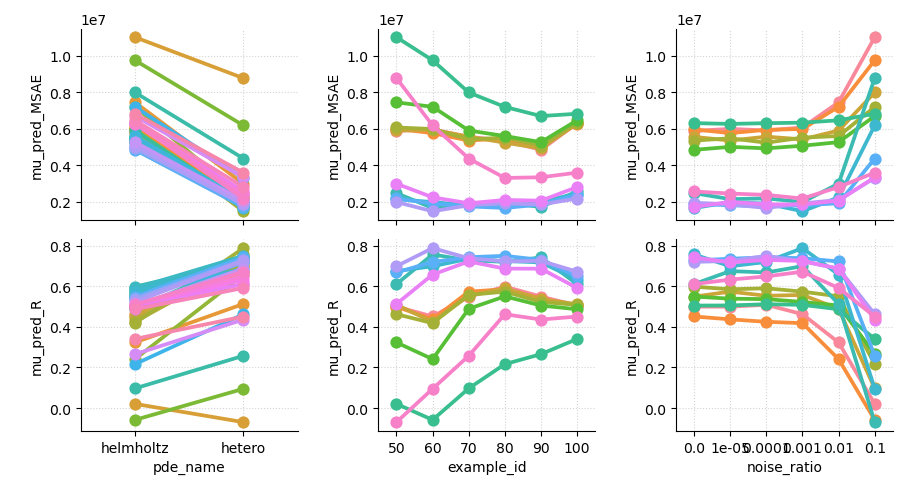

In [11]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')].copy(),
    x=param_cols,
    y=['mu_pred_MSAE', 'mu_pred_R'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [16]:
m['pde_abbrev'] = m.pde_name.map({'helmholtz': 'HH', 'hetero': 'het'}.__getitem__)
m['method'] = 'PINN-' + m['pde_abbrev']

ahi_m = m[m.pde_name == 'helmholtz'].copy()
ahi_m['method'] = 'AHI'
for col in m.columns:
    if col.startswith('direct'):
        ahi_m[col.replace('direct', 'mu')] = m[col]
        
fem_m = m.copy()
fem_m['method'] = 'FEM-' + m['pde_abbrev']
for col in m.columns:
    if col.startswith('fem'):
        fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([ahi_m, fem_m, m])

method_order = ['AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het']
mm['method_index'] = mm['method'].map(method_order.index)
mm = mm.sort_values('method_index')

In [17]:
import matplotlib as mpl
pct_format = mpl.ticker.PercentFormatter()

mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV'] * 100
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV'] * 100

In [18]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [red, yellow, green, cyan, blue]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

<IPython.core.display.Javascript object>


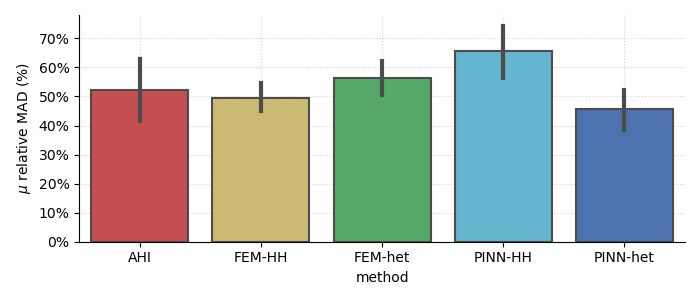

In [19]:
import matplotlib as mpl

fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)].copy(),
    x='method',
    hue='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


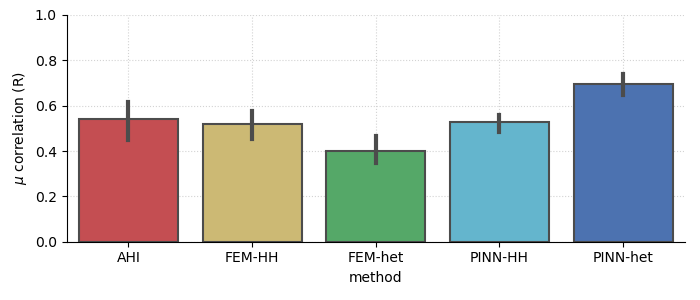

In [20]:
fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & (mm.noise_ratio == 0.0)].copy(),
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


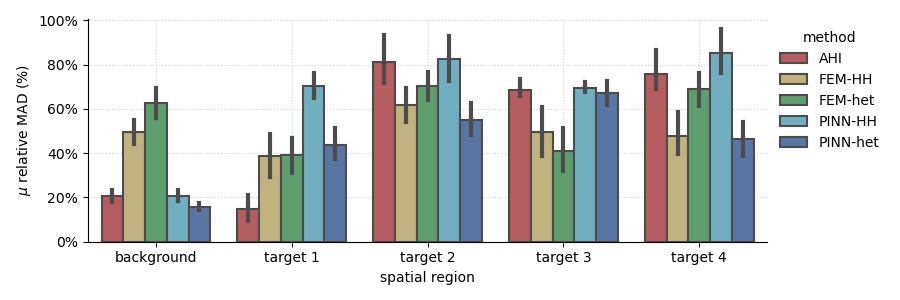

In [21]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_region_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


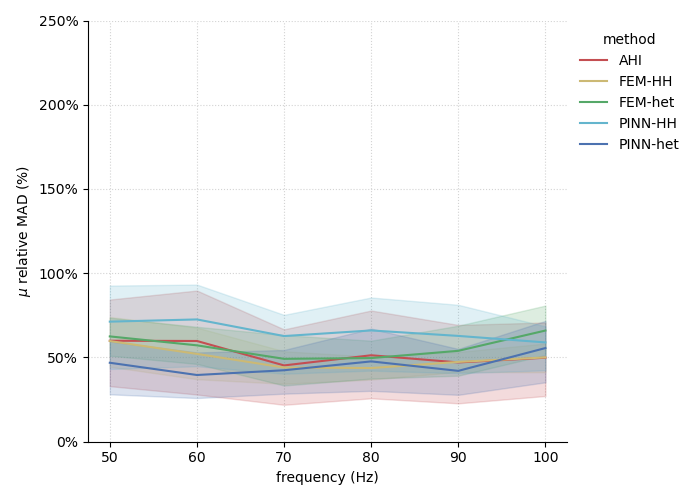

In [22]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 250)
fig.tight_layout()

fig.axes[0].set_xlabel('frequency (Hz)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_frequency_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [23]:
mm['noise_level'] = 10 * np.log10(mm['noise_ratio'])
mm.loc[np.isinf(mm.noise_level), 'noise_level'] = -60

  result = getattr(ufunc, method)(*inputs, **kwargs)



<IPython.core.display.Javascript object>


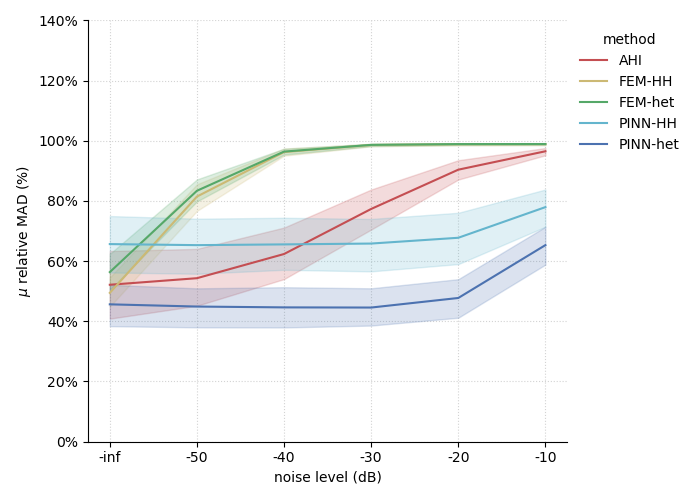

In [24]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all')],
    x='noise_level',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 140)
fig.tight_layout()

fig.axes[0].set_xlabel('noise level (dB)')
fig.axes[0].set_xticks([-60, -50, -40, -30, -20, -10])
fig.axes[0].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_noise_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


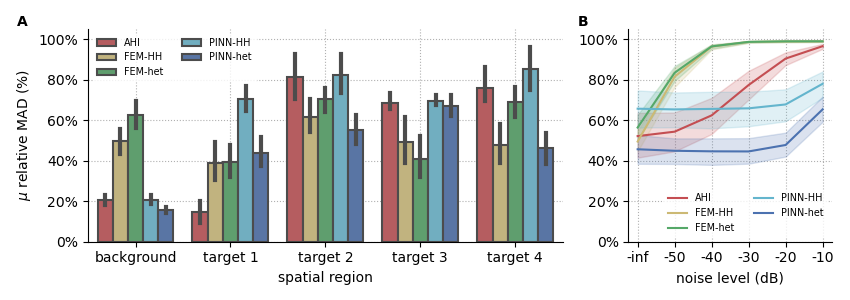

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3), width_ratios=(0.7, 0.3), squeeze=False)

ps.results.barplot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    ax=ax[0,0]
)
ax[0,0].grid(linestyle=':')
ax[0,0].axes.set_axisbelow(True)
ax[0,0].legend(frameon=True, edgecolor='w', loc='upper left', fontsize='x-small', ncol=2)

t = mpl.transforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
ax[0,0].text(
    0, 1, 'A', fontweight='bold', va='bottom', ha='right',
    transform=ax[0,0].transAxes + t
)

ax[0,0].set_ylabel('$\mu$ relative MAD (%)')
ax[0,0].set_ylim(0, 105)
ax[0,0].yaxis.set_major_formatter(pct_format)

ax[0,0].set_xlabel('spatial region')
ax[0,0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

sns.lineplot(
    mm[(mm.spatial_region != 'all')],
    x='noise_level',
    y='mu_pred_MAD_relative',
    hue='method',
    ax=ax[0,1]
)
ax[0,1].grid(linestyle=':')
ax[0,1].axes.set_axisbelow(True)
ax[0,1].legend(frameon=True, edgecolor='w', fontsize='x-small', ncol=2, loc='lower right')

t = mpl.transforms.ScaledTranslation(-0.4, 0, fig.dpi_scale_trans)
ax[0,1].text(0, 1, 'B', fontweight='bold', va='bottom', ha='right', transform=ax[0,1].transAxes + t)

ax[0,1].set_ylabel(None)
ax[0,1].set_ylim(0, 105)
ax[0,1].yaxis.set_major_formatter(pct_format)

ax[0,1].set_xlabel('noise level (dB)')
ax[0,1].set_xticks([-60, -50, -40, -30, -20, -10])
ax[0,1].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

sns.despine(fig)
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_plots.{ext}', bbox_inches='tight', dpi=200)

In [39]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('tab10')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue,
    purple=purple
)

Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc


<IPython.core.display.Javascript object>


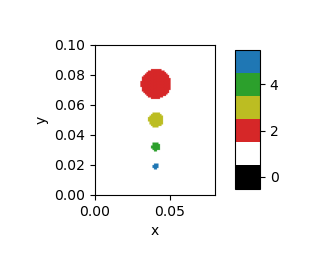

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


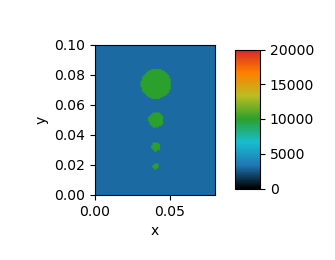

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



In [84]:
wave_kws = dict(vmin=-1e-2, vmax=1e-2, cmap=mre_pinn.visual.wave_color_map())
elast_kws = dict(vmin=0, vmax=20e3, cmap=mre_pinn.visual.mre_color_map(symmetric=False))

dataset = mre_pinn.data.MREDataset.load_xarrays(
    xarray_dir='../data/BIOQIC/fem_box'
)
dataset[0].view('mre_mask', ax_height=1.5, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/fem_box_regions.png', dpi=200, bbox_inches='tight')
dataset[0].view('mre', ax_height=1.5, space=0.2, **elast_kws)
plt.gcf().tight_layout()
plt.savefig('images/fem_box_mre.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


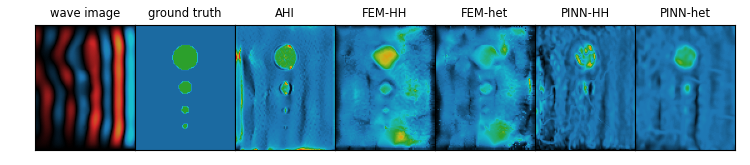

Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_helmholtz/train_fem_box_90_0e+00_0_60_helmholtz_direct.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_helmholtz/train_fem_box_90_0e+00_0_60_helmholtz_fem.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_hetero/train_fem_box_90_0e+00_0_60_hetero_fem.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_helmholtz/train_fem_box_90_0e+00_0_60_helmholtz_elastogram.nc
Loading 2023-2-24_sim_noise2/train_fem_box_90_0e+00_0_60_hetero/train_fem_box_90_0e+00_0_60_hetero_elastogram.nc


In [85]:
%autoreload
import mre_pinn

# image grid

image_names = [
    'wave image', 'ground truth', 'AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het'
]

expt_name = '2023-2-24_sim_noise2' 
name = 'train_fem_box_{example_id}_{noise_ratio:.0e}_{savgol_filter}_{omega}_{pde_name}'

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    noise_ratio = 0
    savgol_filter = 0
    omega = 60

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(
        n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25)
    )
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0 and False:
                ax.set_ylabel(example_id + ' Hz', fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])
            
            if image_name == 'regions':
                array = example.mre_mask.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)

            elif image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = wave_kws
                array = array.real

            elif image_name in {'ground truth', 'elastogram'}:
                array = example.mre.sel(z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'AHI':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)
                
            elif image_name == 'FEM-HH':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'FEM-het':
                job_name = name.format(
                    example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-HH':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-het':
                job_name = name.format(
                    example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio, omega=omega, savgol_filter=savgol_filter
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = elast_kws
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)
            
    return fig

fig = plot_image_grid(['90']) #['50', '60', '70', '80', '90', '100'])
#fig0 = plot_image_grid(['50', '60', '70'])
#fig1 = plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_wave_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/fem_box_wave_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/fem_box_wave_grid1.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


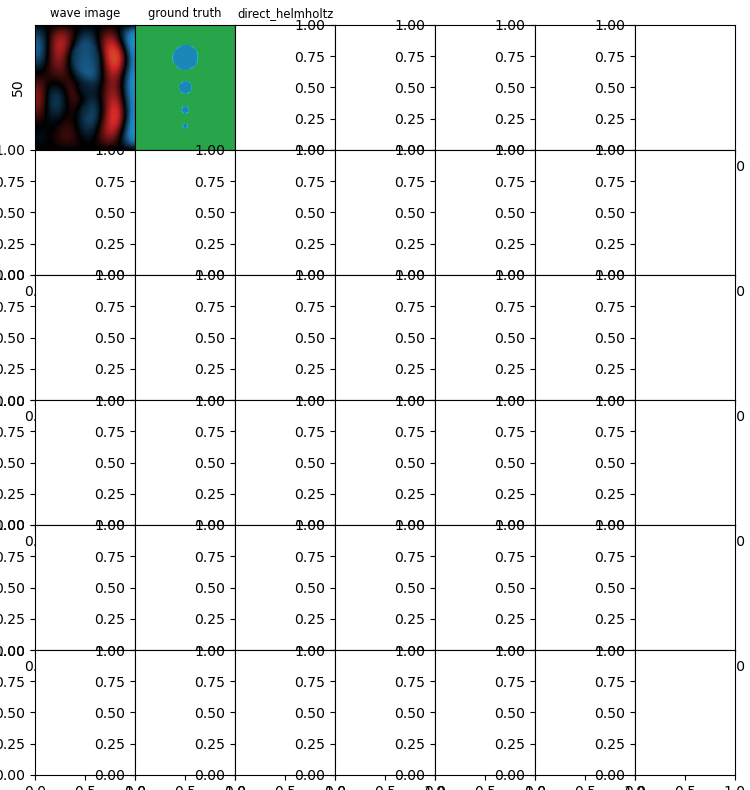

Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc


KeyError: 'savgol_filter'

In [83]:
%autoreload
import mre_pinn

image_names = ['wave image', 'ground truth', 'direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real

            elif image_name == 'ground truth':
                array = example.mre.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'direct_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'])
#fig0 = plot_image_grid(['50', '60', '70'])
#fig1 = plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_example_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/fem_box_example_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/fem_box_example_grid1.{ext}', bbox_inches='tight', dpi=200)

In [ ]:
%autoreload
import mre_pinn

# multifrequency

image_names = [
    'ground truth',
    'direct_helmholtz',
    'FEM_helmholtz',
    'FEM_hetero',
    'PINN_helmholtz',
    'PINN_hetero'
]

def plot_image_grid(example_ids, noise_ratios):
    n_rows = len(noise_ratios)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for col_idx, image_name in enumerate(image_names):
        for row_idx, noise_ratio in enumerate(noise_ratios):
            mean_array = 0
            for example_id in example_ids:
                example = mre_pinn.data.MREExample.load_xarrays(
                    '../data/BIOQIC/fem_box', example_id
                )
                ax = axes[row_idx,col_idx]
                #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
                if col_idx == 0:
                    noise_level = 10 * np.log10(noise_ratio)
                    ax.set_ylabel('{:.0f} dB'.format(noise_level), fontsize='medium')
                if row_idx == 0:
                    ax.set_title(image_name, fontsize='small')
                ax.set_yticks([])
                ax.set_xticks([])

                if image_name == 'wave image':
                    array = example.wave.sel(component='z', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = array.real

                elif image_name == 'ground truth':
                    array = example.mre.sel(z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'direct_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                mean_array += array / len(example_ids)

            mre_pinn.visual.imshow(ax, mean_array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'], [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fig0 = plot_image_grid(['50', '60', '70', '80', '90', '100'], [0, 1e-5, 1e-4])
fig1 = plot_image_grid(['50', '60', '70', '80', '90', '100'], [1e-3, 1e-2, 1e-1])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_multifreq_grid.{ext}', bbox_inches='tight', dpi=200)
    fig0.savefig(f'images/fem_box_multifreq_grid0.{ext}', bbox_inches='tight', dpi=200)
    fig1.savefig(f'images/fem_box_multifreqe_grid1.{ext}', bbox_inches='tight', dpi=200)